Found 5525 images belonging to 8 classes.
Found 797 images belonging to 8 classes.
Label Mappings for classes present in the training and validation datasets

0 : Asian Hornet Images
1 : Asian giant Hornet 
2 : Carpenter Bee 1000
3 : Common wasp 1000
4 : European hornet extra
5 : Honey Bee new
6 : Hoverfly extra
7 : Oriental Hornet extra
Processing fold 1...
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1932s 21s/step - accuracy: 0.2162 - loss: 5.4945 - val_accuracy: 0.1518 - val_loss: 4.0314 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.2754 - loss: 3.9345 - val_accuracy: 0.1330 - val_loss: 3.9602 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3278 - loss: 3.6017 - val_accuracy: 0.2033 - val_loss: 3.7959 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.3283 - loss: 3.4729 - val_accuracy: 0.2647 - val_loss: 3.5672 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━

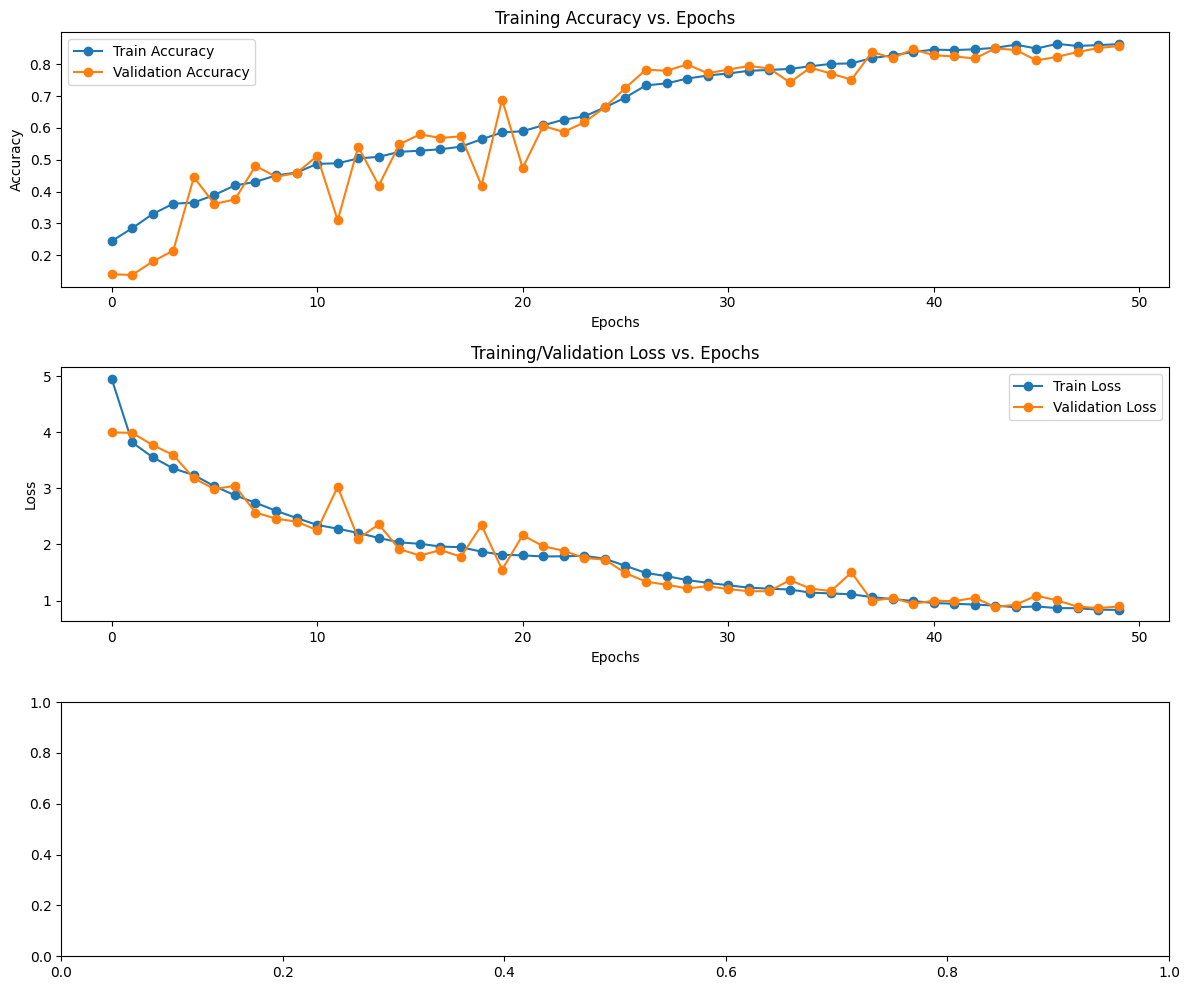

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define directories
base_dir = '/content/drive/MyDrive/Dataset 2nd July'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, width_shift_range=0.2,
                                   height_shift_range=0.2, rotation_range=20,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest',
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   batch_size=64,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(test_dir,
                                                             target_size=(224, 224),
                                                             batch_size=64,
                                                             class_mode='categorical',
                                                             shuffle=True)

# Labels mapping
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

# Model creation function
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='same', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(units=512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(units=8, activation='softmax')
    ])
    return model

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

for train_idx, val_idx in skf.split(train_generator.filenames, train_generator.classes):
    print(f'Processing fold {fold_no}...')

    # Model creation
    cnn_model = create_model()

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'model_fold_{fold_no}.keras', monitor='val_loss', save_best_only=True)

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Train the model
    history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                           verbose=1, callbacks=[reduce_lr, early_stopping, model_checkpoint])

    # Save the model after each fold
    cnn_model.save(f'model_fold_{fold_no}.keras')
    print(f"Model for Fold {fold_no} saved as model_fold_{fold_no}.keras")

    # Evaluate the model on the test data
    test_loss, test_accuracy = cnn_model.evaluate(validation_generator, verbose=1)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Increment the fold number
    fold_no += 1

# Final model save
cnn_model.save('final_model.keras')
print("Final model saved as final_model.keras")

# Plotting code (same as before)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Learning Rate')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
K_FOLD_1=85.44
K_FOLD_2=87.20
K_FOLD_3=87.57
K_FOLD_4=85.19
K_FOLD_5=85.06

In [ ]:
import numpy as np

# K-fold accuracies
accuracies = [85.44, 87.20, 87.57, 85.19, 85.06]

# Convert percentages to decimals
accuracies = np.array(accuracies)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)

# Calculate standard deviation of accuracies
std_deviation = np.std(accuracies)

# Calculate variance of accuracies
variance = np.var(accuracies)

# Calculate the coefficient of variation (CV) if needed
cv = std_deviation / mean_accuracy

print(f"Mean Accuracy: {mean_accuracy:.2f}%")
print(f"Standard Deviation: {std_deviation:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Coefficient of Variation (CV): {cv:.4f}")


Mean Accuracy: 86.09%
Standard Deviation: 1.07
Variance: 1.14
Coefficient of Variation (CV): 0.0124
